In [1]:
import numpy as np
import scipy
from scipy import io
import matplotlib.pyplot as plt
from quaternion import Quaternion
from scipy.constants import g
import os

# IMU Data

In [2]:
data_num = 3
imu  = io.loadmat('imu/imuRaw' + str(data_num) + '.mat')
accel = imu['vals'][0:3,:]
gyro = imu['vals'][3:6,:]
T = np.shape(imu['ts'])[1]


In [3]:
ax_raw, ay_raw, az_raw = accel[0,:], accel[1,:], accel[2,:]
gz_raw, gx_raw, gy_raw = gyro[0,:], gyro[1,:], gyro[2,:]

In [4]:
imu_t = []
vicon_t = []
ax_rawf = []
ay_rawf = []
az_rawf = []
gz_rawf = []
gx_rawf = []
gy_rawf = []
axf = []
ayf = []
azf = []
omega_xf = []
omega_yf = []
omega_zf = []
for i in range(1,4):
    data_num = i
    imu  = io.loadmat('imu/imuRaw' + str(data_num) + '.mat')
    accel = imu['vals'][0:3,:]
    gyro = imu['vals'][3:6,:]
    T = np.shape(imu['ts'])[1]
    ax_raw, ay_raw, az_raw = accel[0,:], accel[1,:], accel[2,:]
    gz_raw, gx_raw, gy_raw = gyro[0,:], gyro[1,:], gyro[2,:]

    ax_rawf.append(ax_raw)
    ay_rawf.append(ay_raw)
    az_rawf.append(az_raw)
    gz_rawf.append(gz_raw)
    gx_rawf.append(gx_raw)
    gy_rawf.append(gy_raw)
    imu_t.append(imu['ts'].flatten())

    vicon = io.loadmat('vicon/viconRot' + str(data_num) + '.mat')
    v_time = vicon['ts'].flatten()
    Rots = vicon['rots'].T
    Accelerations = Rots @ np.array([0.0,0.0,g]) #Getting ground truth accelerations
    ax, ay, az = Accelerations[:,0], Accelerations[:,1], Accelerations[:,2]
    
    # Getting angualr accelerations from VICON data
    R_dot = np.diff(Rots, axis = 0)
    dt = np.diff(v_time)
    omega_x = np.zeros(len(v_time))
    omega_y = np.zeros(len(v_time))
    omega_z = np.zeros(len(v_time))
    qs = []
    for i in range(len(v_time)):
        q = Quaternion()
        q.from_rotm(Rots[i])
        qs.append(q)

    for i in range(1, len(v_time)):
        temp = Quaternion()
        temp = qs[i-1].inv()*qs[i]
        omega_x[i], omega_y[i], omega_z[i] = temp.axis_angle(v_time[i]-v_time[i-1])

    # omega_x = np.convolve(np.nan_to_num(np.append(0, omega_x)), np.ones(10)/10, mode='same')
    # omega_y = np.convolve(np.nan_to_num(np.append(0, omega_y)), np.ones(10)/10, mode='same')
    # omega_z = np.convolve(np.nan_to_num(np.append(0, omega_z)), np.ones(10)/10, mode='same')


    for i in range(len(omega_x)):
        if abs(omega_x[i]) > 5:
            omega_x[i] = omega_x[i-1]
        if abs(omega_y[i]) > 5:
            omega_y[i] = omega_y[i-1]
        if abs(omega_z[i]) > 5:
            omega_z[i] = omega_z[i-1]

    omega_x = np.convolve(omega_x, np.ones(10)/10, mode='same')
    omega_y = np.convolve(omega_y, np.ones(10)/10, mode='same')
    omega_z = np.convolve(omega_z, np.ones(10)/10, mode='same')

    axf.append(ax)
    ayf.append(ay)
    azf.append(az)
    omega_xf.append(omega_x)
    omega_yf.append(omega_y)
    omega_zf.append(omega_z)
    vicon_t.append(v_time)
    

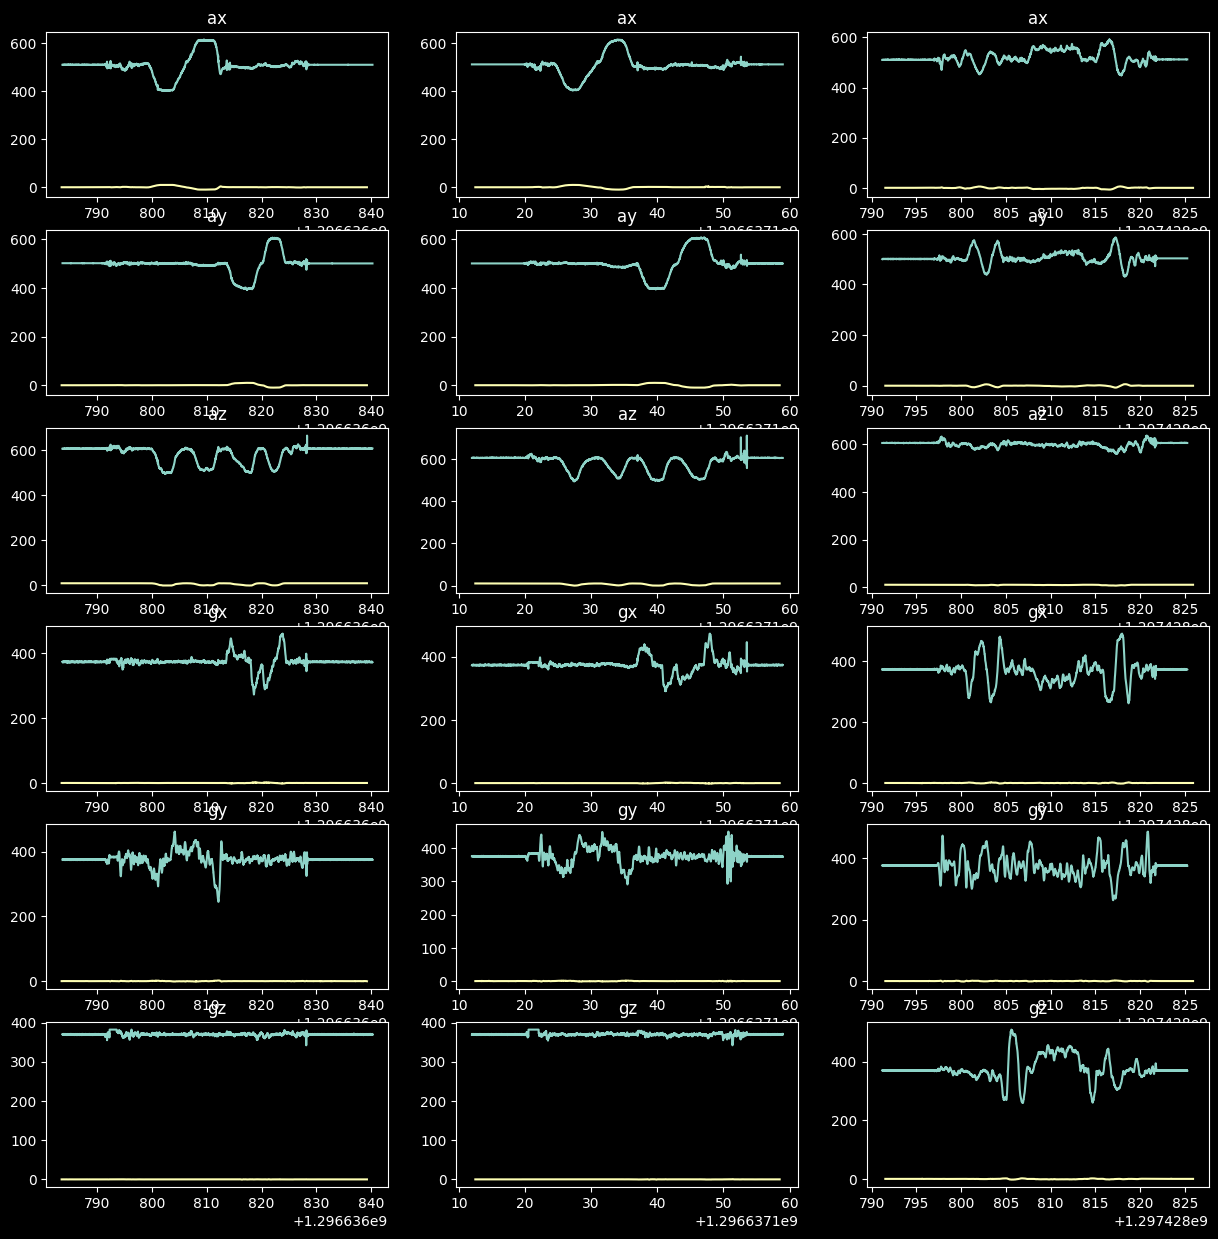

In [5]:
#plot with 18 subplots
fig, axs = plt.subplots(6, 3, figsize=(15, 15))
for i in range(3):
    axs[0, i].plot(imu_t[i], ax_rawf[i])
    axs[0, i].plot(vicon_t[i], axf[i])
    axs[0, i].set_title('ax')
    axs[1, i].plot(imu_t[i], ay_rawf[i])
    axs[1, i].plot(vicon_t[i], ayf[i])
    axs[1, i].set_title('ay')
    axs[2, i].plot(imu_t[i], az_rawf[i])
    axs[2, i].plot(vicon_t[i], azf[i])
    axs[2, i].set_title('az')
    axs[3, i].plot(imu_t[i], gx_rawf[i])
    axs[3, i].plot(vicon_t[i], omega_xf[i])
    axs[3, i].set_title('gx')
    axs[4, i].plot(imu_t[i], gy_rawf[i])
    axs[4, i].plot(vicon_t[i], omega_yf[i])
    axs[4, i].set_title('gy')
    axs[5, i].plot(imu_t[i], gz_rawf[i])
    axs[5, i].plot(vicon_t[i], omega_zf[i])
    axs[5, i].set_title('gz')
plt.show()



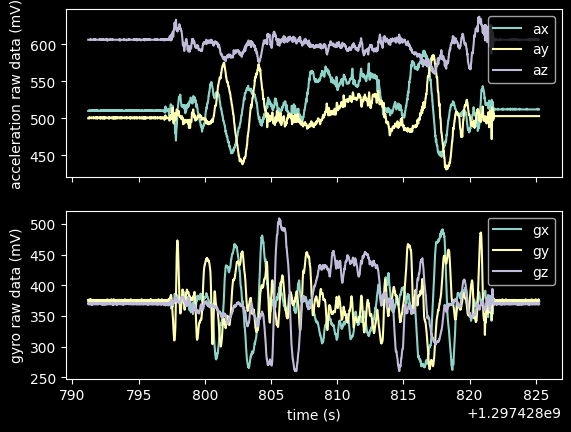

In [6]:
#matplotlib with two subplots one below the other
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)   
ax1.plot(imu['ts'][0,:], ax_raw, label='ax')
ax1.plot(imu['ts'][0,:], ay_raw, label='ay')
ax1.plot(imu['ts'][0,:], az_raw, label='az')
ax1.set_ylabel('acceleration raw data (mV)')
ax1.legend()
ax2.plot(imu['ts'][0,:], gx_raw, label='gx')
ax2.plot(imu['ts'][0,:], gy_raw, label='gy')
ax2.plot(imu['ts'][0,:], gz_raw, label='gz')
ax2.set_ylabel('gyro raw data (mV)')
ax2.legend()
plt.xlabel('time (s)')  
plt.show()

# VICON Data

In [7]:
vicon = io.loadmat('vicon/viconRot' + str(data_num) + '.mat')
vicon['rots'].shape

(3, 3, 3433)

In [8]:
v_time = vicon['ts'].flatten()

In [9]:
Rots = vicon['rots'].T

In [10]:
Accelerations = Rots @ np.array([0.0,0.0,g]) #Getting ground truth accelerations
ax, ay, az = Accelerations[:,0], Accelerations[:,1], Accelerations[:,2]

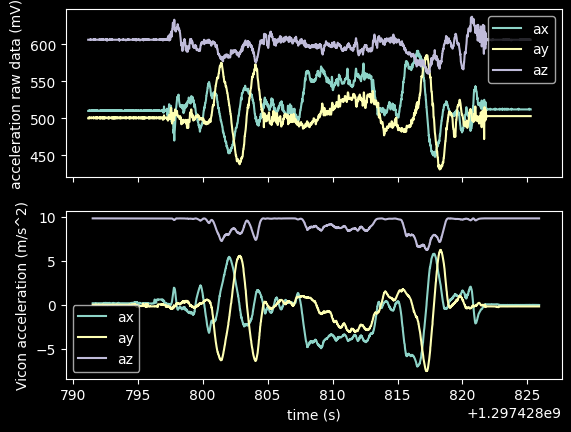

In [11]:
#matplotlib with two subplots one below the other
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)   
ax1.plot(imu['ts'][0,:], ax_raw, label='ax')
ax1.plot(imu['ts'][0,:], ay_raw, label='ay')
ax1.plot(imu['ts'][0,:], az_raw, label='az')
ax1.set_ylabel('acceleration raw data (mV)')
ax1.legend()
ax2.plot(vicon['ts'][0,:], ax, label='ax')
ax2.plot(vicon['ts'][0,:], ay, label='ay')
ax2.plot(vicon['ts'][0,:], az, label='az')
ax2.set_ylabel('Vicon acceleration (m/s^2)')
ax2.legend()
plt.xlabel('time (s)')  
plt.show()


In [12]:
# Getting angualr accelerations from VICON data
R_dot = np.diff(Rots, axis = 0)
dt = np.diff(v_time)
omega_x = np.zeros(len(v_time))
omega_y = np.zeros(len(v_time))
omega_z = np.zeros(len(v_time))
qs = []
for i in range(len(v_time)):
    q = Quaternion()
    q.from_rotm(Rots[i])
    qs.append(q)

for i in range(1, len(v_time)):
    temp = Quaternion()
    temp = qs[i-1].inv()*qs[i]
    omega_x[i], omega_y[i], omega_z[i] = temp.axis_angle(v_time[i]-v_time[i-1])

# omega_x = np.convolve(np.nan_to_num(np.append(0, omega_x)), np.ones(10)/10, mode='same')
# omega_y = np.convolve(np.nan_to_num(np.append(0, omega_y)), np.ones(10)/10, mode='same')
# omega_z = np.convolve(np.nan_to_num(np.append(0, omega_z)), np.ones(10)/10, mode='same')


for i in range(len(omega_x)):
    if abs(omega_x[i]) > 5:
        omega_x[i] = omega_x[i-1]
    if abs(omega_y[i]) > 5:
        omega_y[i] = omega_y[i-1]
    if abs(omega_z[i]) > 5:
        omega_z[i] = omega_z[i-1]

omega_x = np.convolve(omega_x, np.ones(10)/10, mode='same')
omega_y = np.convolve(omega_y, np.ones(10)/10, mode='same')
omega_z = np.convolve(omega_z, np.ones(10)/10, mode='same')

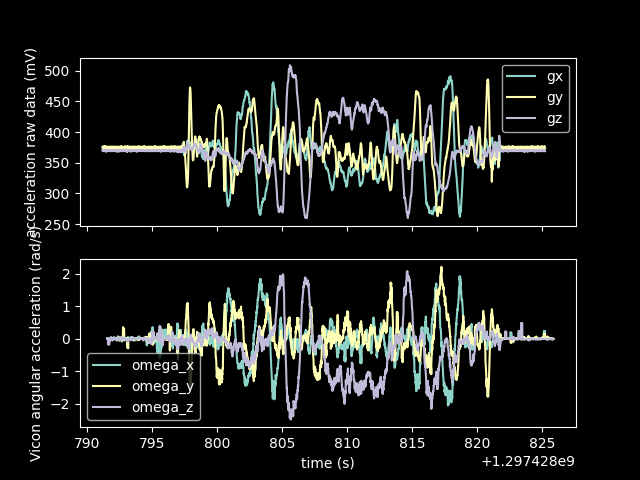

In [13]:
%matplotlib widget
#matplotlib with two subplots one below the other
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)   
ax1.plot(imu['ts'][0,:], gx_raw, label='gx')
ax1.plot(imu['ts'][0,:], gy_raw, label='gy')
ax1.plot(imu['ts'][0,:], gz_raw, label='gz')
ax1.set_ylabel('acceleration raw data (mV)')
ax1.legend()
ax2.plot(vicon['ts'][0,:], omega_x, label='omega_x')
ax2.plot(vicon['ts'][0,:], omega_y, label='omega_y')
ax2.plot(vicon['ts'][0,:], omega_z, label='omega_z')
ax2.set_ylabel('Vicon angular acceleration (rad/s)')
ax2.legend()
plt.xlabel('time (s)')  
plt.show()

# Getting sensitivity and bias

In [14]:
def linear_regression(groundtruth, raw_measurements):
    X = np.vstack((groundtruth, np.ones(groundtruth.shape))).T
    w = (np.linalg.inv(X.T @ X) @ X.T) @ raw_measurements[:len(groundtruth)]
    alpha = w[0]*3300/1023
    bias = w[1]
    return alpha, bias

In [15]:
az_raw_concat = np.append(np.append(az_rawf[0][:min(len(az_rawf[0]), len(azf[0]))], az_rawf[1][:min(len(az_rawf[1]), len(azf[1]))]), az_rawf[2][:min(len(az_rawf[2]), len(azf[2]))])
az_concat = np.append(np.append(azf[0][:min(len(az_rawf[0]), len(azf[0]))], azf[1][:min(len(az_rawf[1]), len(azf[1]))]), azf[2][:min(len(az_rawf[2]), len(azf[2]))])
ax_raw_concat = np.append(np.append(ax_rawf[0][:min(len(ax_rawf[0]), len(axf[0]))], ax_rawf[1][:min(len(ax_rawf[1]), len(axf[1]))]), ax_rawf[2][:min(len(ax_rawf[2]), len(axf[2]))])
ax_concat = np.append(np.append(axf[0][:min(len(ax_rawf[0]), len(axf[0]))], axf[1][:min(len(ax_rawf[1]), len(axf[1]))]), axf[2][:min(len(ax_rawf[2]), len(axf[2]))])
ay_raw_concat = np.append(np.append(ay_rawf[0][:min(len(ay_rawf[0]), len(ayf[0]))], ay_rawf[1][:min(len(ay_rawf[1]), len(ayf[1]))]), ay_rawf[2][:min(len(ay_rawf[2]), len(ayf[2]))])
ay_concat = np.append(np.append(ayf[0][:min(len(ay_rawf[0]), len(ayf[0]))], ayf[1][:min(len(ay_rawf[1]), len(ayf[1]))]), ayf[2][:min(len(ay_rawf[2]), len(ayf[2]))])
gx_raw_concat = np.append(np.append(gx_rawf[0][:min(len(gx_rawf[0]), len(omega_xf[0]))], gx_rawf[1][:min(len(gx_rawf[1]), len(omega_xf[1]))]), gx_rawf[2][:min(len(gx_rawf[2]), len(omega_xf[2]))])
gx_concat = np.append(np.append(omega_xf[0][:min(len(gx_rawf[0]), len(omega_xf[0]))], omega_xf[1][:min(len(gx_rawf[1]), len(omega_xf[1]))]), omega_xf[2][:min(len(gx_rawf[2]), len(omega_xf[2]))])
gy_raw_concat = np.append(np.append(gy_rawf[0][:min(len(gy_rawf[0]), len(omega_yf[0]))], gy_rawf[1][:min(len(gy_rawf[1]), len(omega_yf[1]))]), gy_rawf[2][:min(len(gy_rawf[2]), len(omega_yf[2]))])
gy_concat = np.append(np.append(omega_yf[0][:min(len(gy_rawf[0]), len(omega_yf[0]))], omega_yf[1][:min(len(gy_rawf[1]), len(omega_yf[1]))]), omega_yf[2][:min(len(gy_rawf[2]), len(omega_yf[2]))])
gz_raw_concat = np.append(np.append(gz_rawf[0][:min(len(gz_rawf[0]), len(omega_zf[0]))], gz_rawf[1][:min(len(gz_rawf[1]), len(omega_zf[1]))]), gz_rawf[2][:min(len(gz_rawf[2]), len(omega_zf[2]))])
gz_concat = np.append(np.append(omega_zf[0][:min(len(gz_rawf[0]), len(omega_zf[0]))], omega_zf[1][:min(len(gz_rawf[1]), len(omega_zf[1]))]), omega_zf[2][:min(len(gz_rawf[2]), len(omega_zf[2]))])



In [16]:
alpha_az, bias_az = linear_regression(az_concat, az_raw_concat)
alpha_ax, bias_ax = linear_regression(ax_concat, ax_raw_concat)
alpha_ay, bias_ay = linear_regression(ay_concat, ay_raw_concat)
alpha_gx, bias_gx = linear_regression(gx_concat, gx_raw_concat)
alpha_gy, bias_gy = linear_regression(gy_concat, gy_raw_concat)
alpha_gz, bias_gz = linear_regression(gz_concat, gz_raw_concat)
print('alpha_az: ', alpha_az)
print('bias_az: ', bias_az)
print('alpha_ax: ', alpha_ax)
print('bias_ax: ', bias_ax)
print('alpha_ay: ', alpha_ay)
print('bias_ay: ', bias_ay)
print('alpha_gx: ', alpha_gx)
print('bias_gx: ', bias_gx)
print('alpha_gy: ', alpha_gy)
print('bias_gy: ', bias_gy)
print('alpha_gz: ', alpha_gz)
print('bias_gz: ', bias_gz)


alpha_az:  32.32751930977709
bias_az:  506.2996700837362
alpha_ax:  -32.7032920031149
bias_ax:  511.6137201330549
alpha_ay:  -32.34516704815283
bias_ay:  500.3814941953075
alpha_gx:  -122.42620574410219
bias_gx:  371.85559987319385
alpha_gy:  -98.07153169476835
bias_gy:  375.2600938247318
alpha_gz:  -95.35451403915668
bias_gz:  369.08646025519107


In [18]:
def get_val(raw, bias, alpha):
    return (raw-bias)*3300/(1023*alpha)

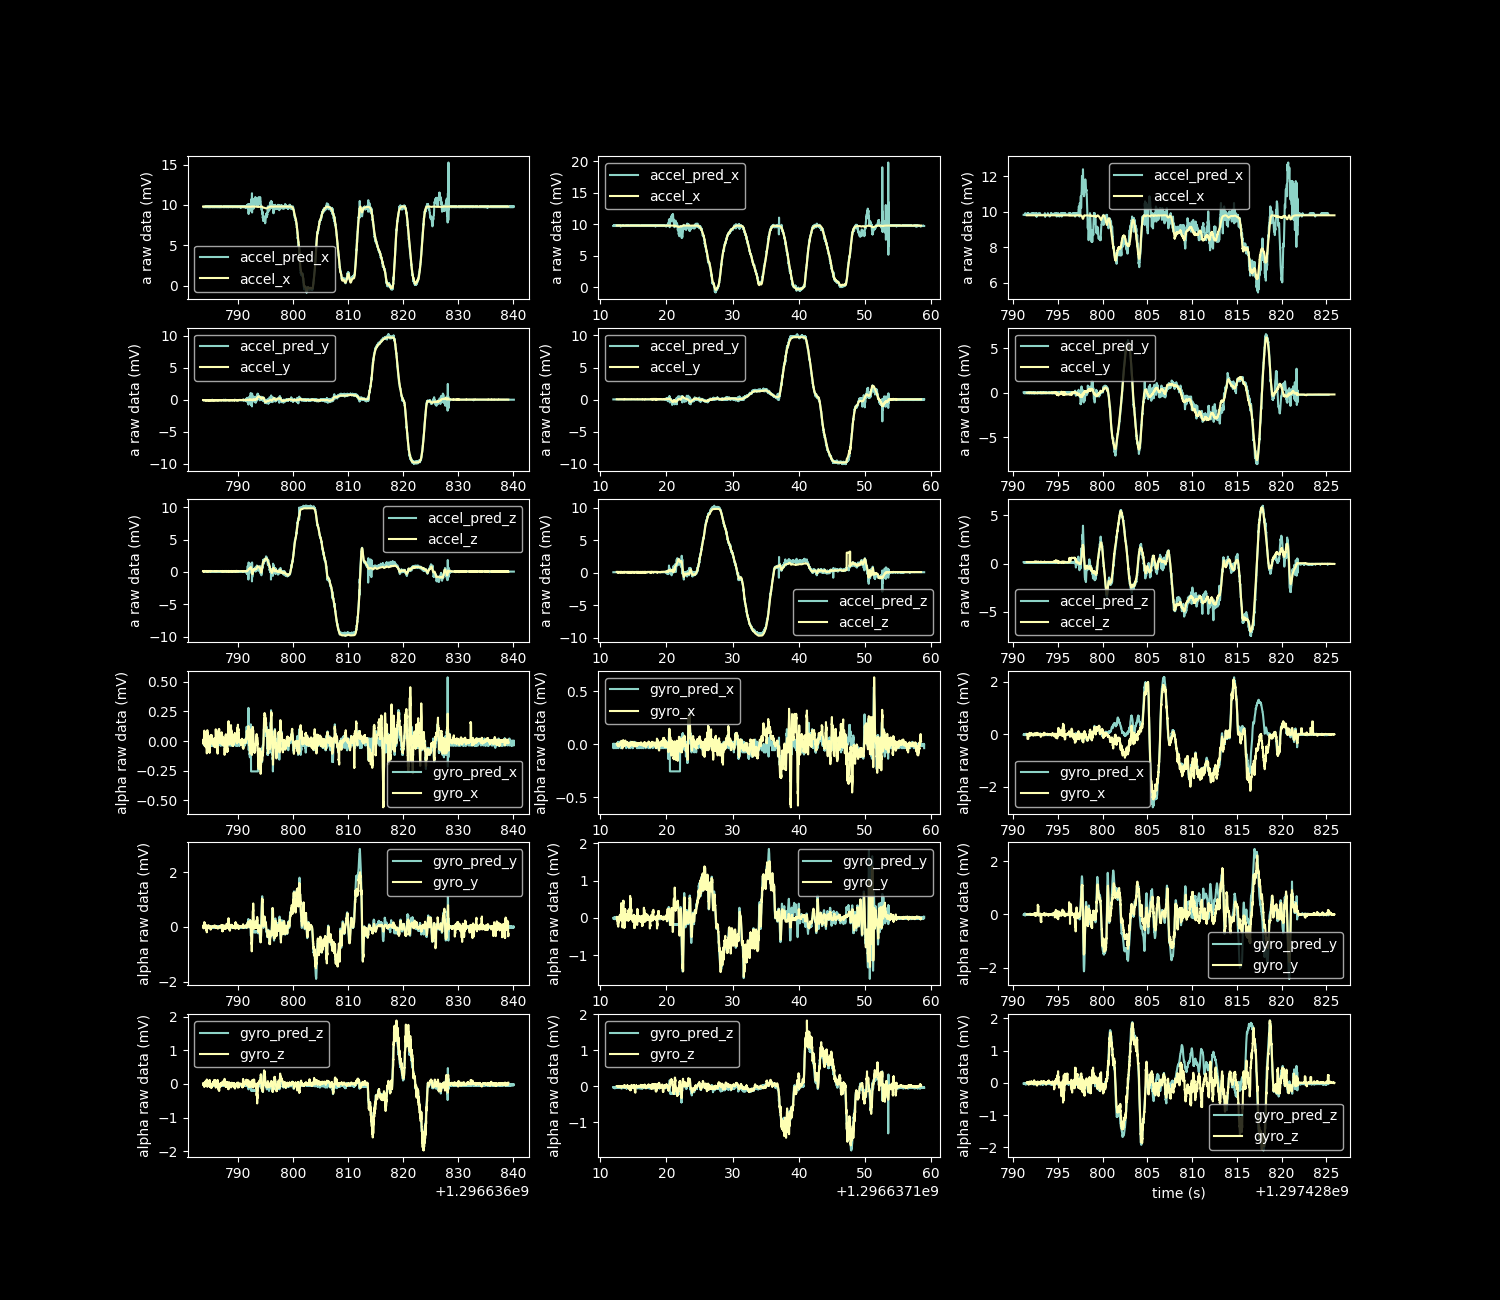

In [19]:
#Plot with 18 subplots

fig, axs = plt.subplots(6, 3, figsize = (15,10*1.3))
for i in range(3):
    axs[0, i].plot(imu_t[i], get_val(az_rawf[i], bias_az-3.75, alpha_az*1.05), label='accel_pred_x')
    axs[0, i].plot(vicon_t[i], azf[i], label='accel_x')
    axs[0, i].set_ylabel('a raw data (mV)')
    axs[0, i].legend()
    axs[1, i].plot(imu_t[i], get_val(ay_rawf[i],  bias_ay, alpha_ay*1.05), label='accel_pred_y')
    axs[1, i].plot(vicon_t[i], ayf[i], label='accel_y')
    axs[1, i].set_ylabel('a raw data (mV)')
    axs[1, i].legend()
    axs[2, i].plot(imu_t[i], get_val(ax_rawf[i],  bias_ax, alpha_ax*1.05), label='accel_pred_z')
    axs[2, i].plot(vicon_t[i], axf[i], label='accel_z')
    axs[2, i].set_ylabel('a raw data (mV)')
    axs[2, i].legend()
    axs[3, i].plot(imu_t[i], get_val(gz_rawf[i],  bias_gz, alpha_gz*1.7), label='gyro_pred_x')
    axs[3, i].plot(vicon_t[i], omega_zf[i], label='gyro_x')
    axs[3, i].set_ylabel('alpha raw data (mV)')
    axs[3, i].legend()
    axs[4, i].plot(imu_t[i], get_val(gy_rawf[i], bias_gy, alpha_gy*1.5), label='gyro_pred_y')
    axs[4, i].plot(vicon_t[i], omega_yf[i], label='gyro_y')
    axs[4, i].set_ylabel('alpha raw data (mV)')
    axs[4, i].legend()
    axs[5, i].plot(imu_t[i], get_val(gx_rawf[i], bias_gx, alpha_gx*1.5), label='gyro_pred_z')
    axs[5, i].plot(vicon_t[i], omega_xf[i], label='gyro_z')
    axs[5, i].set_ylabel('alpha raw data (mV)')
    axs[5, i].legend()
    plt.xlabel('time (s)')
plt.show()



In [ ]:
#Plot with 18 subplots

fig, axs = plt.subplots(6, 3, figsize = (15,10*1.3))
for i in range(3):
    axs[0, i].plot(imu_t[i], get_val(az_rawf[i], bias_az-3.75, alpha_az*1.05), label='accel_pred_x')
    axs[0, i].plot(vicon_t[i], azf[i], label='accel_x')
    axs[0, i].set_ylabel('a raw data (mV)')
    axs[0, i].legend()
    axs[1, i].plot(imu_t[i], get_val(ay_rawf[i],  bias_ay, alpha_ay*1.05), label='accel_pred_y')
    axs[1, i].plot(vicon_t[i], ayf[i], label='accel_y')
    axs[1, i].set_ylabel('a raw data (mV)')
    axs[1, i].legend()
    axs[2, i].plot(imu_t[i], get_val(ax_rawf[i],  bias_ax, alpha_ax*1.05), label='accel_pred_z')
    axs[2, i].plot(vicon_t[i], axf[i], label='accel_z')
    axs[2, i].set_ylabel('a raw data (mV)')
    axs[2, i].legend()
    axs[3, i].plot(imu_t[i], get_val(gz_rawf[i],  bias_gz, alpha_gz*1.7), label='gyro_pred_x')
    axs[3, i].plot(vicon_t[i], omega_zf[i], label='gyro_x')
    axs[3, i].set_ylabel('alpha raw data (mV)')
    axs[3, i].legend()
    axs[4, i].plot(imu_t[i], get_val(gy_rawf[i], bias_gy, alpha_gy*1.5), label='gyro_pred_y')
    axs[4, i].plot(vicon_t[i], omega_yf[i], label='gyro_y')
    axs[4, i].set_ylabel('alpha raw data (mV)')
    axs[4, i].legend()
    axs[5, i].plot(imu_t[i], get_val(gx_rawf[i], bias_gx, alpha_gx*1.5), label='gyro_pred_z')
    axs[5, i].plot(vicon_t[i], omega_xf[i], label='gyro_z')
    axs[5, i].set_ylabel('alpha raw data (mV)')
    axs[5, i].legend()
    plt.xlabel('time (s)')
plt.show()

In [35]:
from scipy import signal
t_common = np.linspace(min(imu['ts'].flatten()[0], vicon['ts'].flatten()[0]), min(imu['ts'].flatten()[-1], vicon['ts'].flatten()[-1]), min(len(imu['ts'].flatten()), len(vicon['ts'].flatten())))
s1 = get_val(az_rawf[i], bias_az-3.75, alpha_az*1.05)[:min(len(imu['ts'].flatten()), len(vicon['ts'].flatten()))]
s2 = azf[i][:min(len(imu['ts'].flatten()), len(vicon['ts'].flatten()))]
t1 = imu['ts'].flatten()
t2 = vicon['ts'].flatten()
# Resample s1 and s2 to a common time axis t_common
num = len(t_common)
s1_resampled = signal.resample(s1, num, t=t1)
s2_resampled = signal.resample(s2, num, t=t2)

In [37]:
s1_resampled

(array([9.83124473, 9.83124473, 9.83124473, ..., 9.83124473, 9.83124473,
        9.83124473]),
 array([1.29742879e+09, 1.29742879e+09, 1.29742879e+09, ...,
        1.29742883e+09, 1.29742883e+09, 1.29742883e+09]))

In [38]:
get_val(az_rawf[i], bias_az-3.75, alpha_az*1.05)[:min(len(imu['ts'].flatten()), len(vicon['ts'].flatten()))]

array([9.83124473, 9.83124473, 9.83124473, ..., 9.83124473, 9.83124473,
       9.83124473])

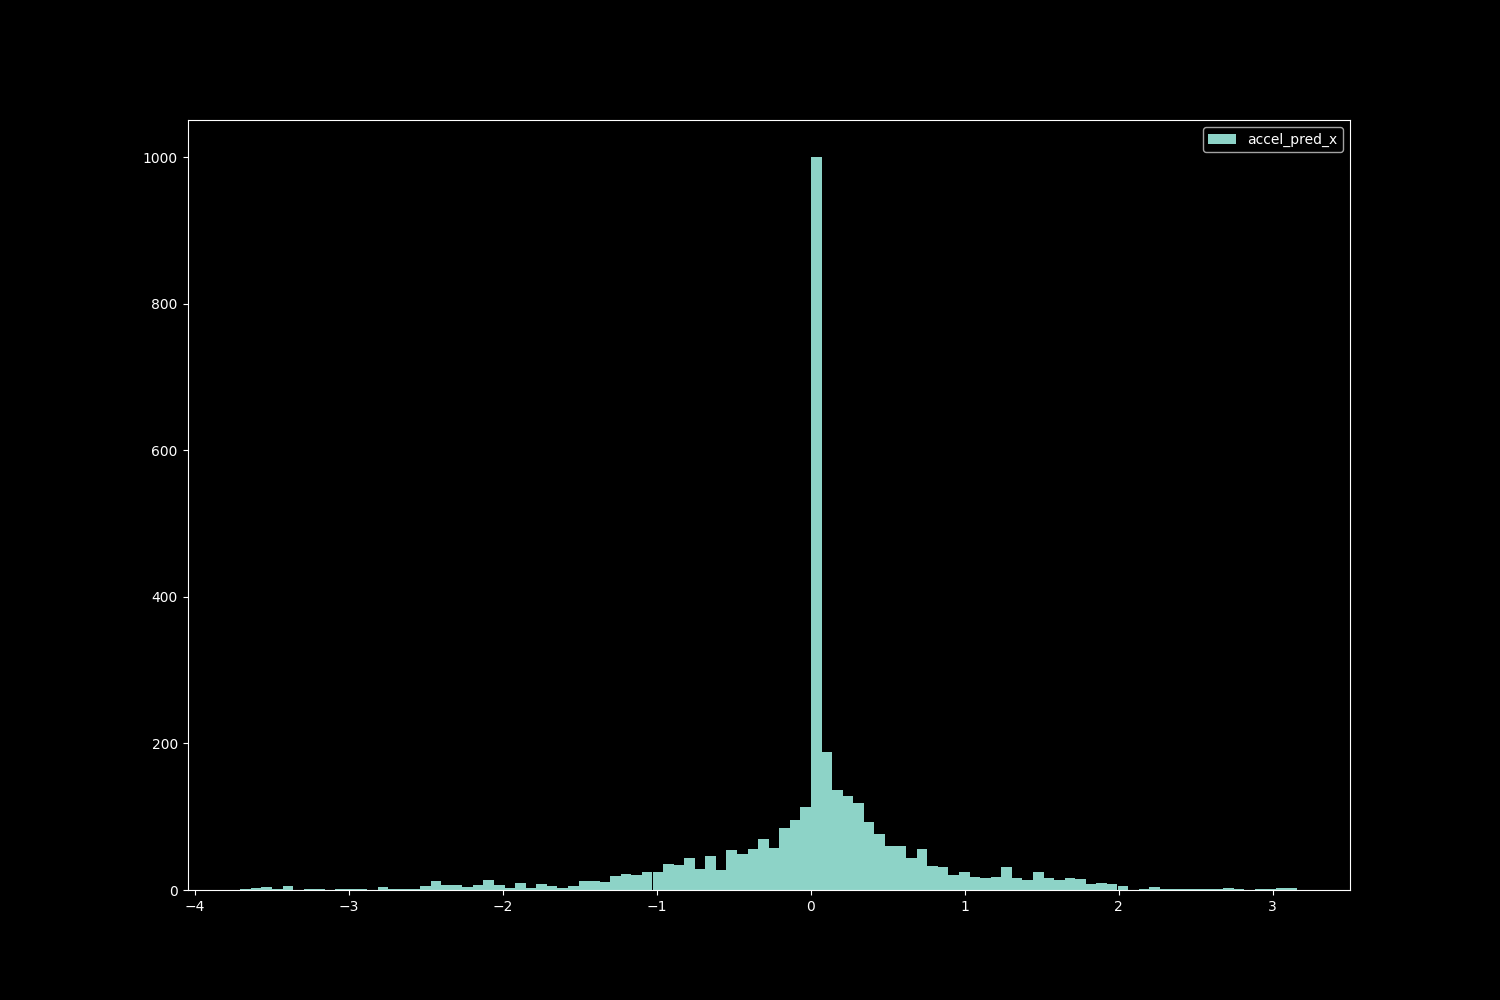

In [44]:
fig = plt.figure(figsize=(15, 10))
plt.hist(s1_resampled[0] - s2_resampled[0], bins = 100,  label='accel_pred_x')
# plt.plot(t_common, s2_resampled[0], label='accel_x')
plt.legend()
plt.show()

In [46]:
(s1_resampled[0] - s2_resampled[0]).mean()

0.02796909056855419

In [31]:
from scipy import signal
t_common = np.linspace(min(imu['ts'].flatten()[0], vicon['ts'].flatten()[0]), min(imu['ts'].flatten()[-1], vicon['ts'].flatten()[-1]), min(len(imu['ts'].flatten()), len(vicon['ts'].flatten())))
s1 = get_val(az_rawf[i], bias_az-3.75, alpha_az*1.05)[:min(len(imu['ts'].flatten()), len(vicon['ts'].flatten()))]
s2 = azf[i][:min(len(imu['ts'].flatten()), len(vicon['ts'].flatten()))]
t1 = imu['ts'].flatten()
t2 = vicon['ts'].flatten()
# Resample s1 and s2 to a common time axis t_common
num = len(t_common)
s1_resampled = signal.resample(s1, num, t=t1)
s2_resampled = signal.resample(s2, num, t=t2)

3404

In [53]:
def Sensordiff(t1, s1, t2, s2):
    t_common = np.linspace(min(t1.flatten()[0], t2.flatten()[0]), min(t1.flatten()[-1], t2.flatten()[-1]), min(len(t1.flatten()), len(t2.flatten())))
    s1_resampled = signal.resample(s1, len(t_common), t=t1)
    s2_resampled = signal.resample(s2, len(t_common), t=t2)
    return (s1_resampled[0] - s2_resampled[0])

In [61]:
az_diff = np.zeros(1)
ay_diff = np.zeros(1)
ax_diff = np.zeros(1)
gx_diff = np.zeros(1)
gy_diff = np.zeros(1)
gz_diff = np.zeros(1)

for i in range(3):
    az_diff = np.append(az_diff, Sensordiff(imu_t[0], get_val(az_rawf[i], bias_az-3.75, alpha_az*1.05), vicon_t[0], azf[i]))
    ay_diff = np.append(ay_diff, Sensordiff(imu_t[0], get_val(ay_rawf[i], bias_ay, alpha_ay*1.05), vicon_t[0], ayf[i]))
    ax_diff = np.append(ax_diff, Sensordiff(imu_t[0], get_val(ax_rawf[i], bias_ax, alpha_ax*1.05), vicon_t[0], axf[i]))
    gx_diff = np.append(gx_diff, Sensordiff(imu_t[0], get_val(gz_rawf[i], bias_gz, alpha_gz*1.7), vicon_t[0], omega_zf[i]))
    gy_diff = np.append(gy_diff, Sensordiff(imu_t[0], get_val(gy_rawf[i], bias_gy, alpha_gy*1.5), vicon_t[0], omega_yf[i]))
    gz_diff = np.append(gz_diff, Sensordiff(imu_t[0], get_val(gx_rawf[i], bias_gx, alpha_gx*1.5), vicon_t[0], omega_xf[i]))

In [66]:
np.array([ax_diff.var(), ay_diff.var(), az_diff.var(), gx_diff.var(), gy_diff.var(), gz_diff.var()])

array([2.12152214, 2.58091551, 1.4783665 , 0.25833854, 0.31113115,
       0.27795984])

In [64]:
np.diag([2300,2300,2300,1000,1000,800]).astype(float)/100

array([[23.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 23.,  0.,  0.,  0.,  0.],
       [ 0.,  0., 23.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 10.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  8.]])

In [71]:
axes = np.array([q.axis_angle() for q in qs])
axes

array([[ 0.00231341,  0.0160719 ,  0.08383884],
       [ 0.00220655,  0.0162345 ,  0.08385655],
       [ 0.00250435,  0.01596682,  0.08359201],
       ...,
       [ 0.02070207, -0.00395463,  0.05970364],
       [ 0.02046631, -0.0046494 ,  0.05988886],
       [ 0.02047242, -0.00460144,  0.05984013]])

In [75]:
(axes - axes.mean(axis = 0)).T @(axes - axes.mean(axis = 0))

array([[ 230.22843281,   37.02859132, -336.94607662],
       [  37.02859132,  213.99614463, -213.36026075],
       [-336.94607662, -213.36026075, 1815.39769134]])

In [76]:
omega_x.var()

0.310445773272112

In [77]:
omega_y.var()

0.27044788347560644

In [78]:
omega_z.var()

0.5747869637134595